# 2022 general election for Oakland Unified Board of Education District 4

This notebook creates a pref_voting ProfileWithTies object for the 2022 general election for Oakland Unified Board of Education District 4 (see https://ballotpedia.org/Oakland_Unified_School_District,_California,_elections\_(2022)), using the CSV file available at https://dataverse.harvard.edu/file.xhtml?fileId=6938408&version=9.0.

This election is of interest because it involved a majority cycle. It also involved a tabulation error for IRV: initially Nick Resnick was declared the winner, but after the tabulation error was discovered, Mike Hutchinson was declared the winner (see https://oaklandside.org/2023/03/07/judge-declares-mike-hutchinson-winner-of-ousd-school-board-race/).

We note that only two voters submitted rankings with overvotes. We allow these ballots in the profile below, ignoring the overvotes.

In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
import csv
import pandas as pd
from collections import Counter, defaultdict

{0: 'NICK RESNICK', 1: 'MIKE HUTCHINSON', 2: 'PECOLIA MANIGO', 3: 'Write-in'}
+------+-----+------+------+------+------+------+------+-----+------+------+------+-----+------+------+----+----+-----+----+----+----+---+-----+----+---+---+----+---+---+---+----+---+---+---+----+----+---+---+---+----+----+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 2286 | 908 | 3708 | 2161 | 4342 | 1796 | 1844 | 2223 | 720 | 2228 | 2428 | 1217 | 917 | 1413 | 1712 | 15 | 53 | 526 | 26 | 38 | 12 | 2 | 139 | 19 | 6 | 6 | 27 | 5 | 3 | 3 | 35 | 3 | 7 | 5 | 10 | 14 | 2 | 6 | 6 | 12 | 10 | 5 | 9 | 2 | 18 | 7 | 4 | 3 | 6 | 8 | 1 | 2 | 1 | 4 | 6 | 1 | 6 | 2 | 2 | 1 | 1 | 1 |
+------+-----+------+------+------+------+------+------+-----+------+------+------+-----+------+------+----+----+-----+----+----+----+---+-----+----+---+---+----+---+---+---+----+---+---+---+----+----+---+---+---+----+----+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+

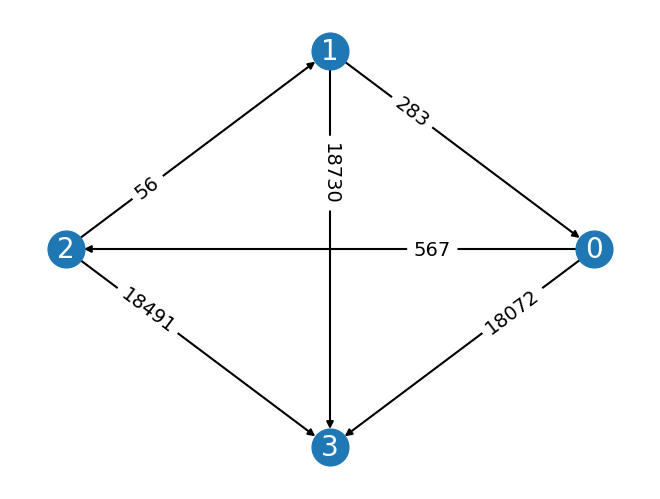

Borda (for Truncated Profiles) winner is {1}
Instant Runoff (Truncated Linear Orders) winner is {1}
Minimax winner is {1}
Plurality winner is {0}


In [2]:
# Load the CSV file
file_path = 'edata/Oakland_11082022_Schoolboarddistrict4.csv'  # Replace with your CSV file path
election_data = pd.read_csv(file_path)

# Function to process each voter's rankings, ignoring "overvote"
def process_rankings(row):
    seen_candidates = set()
    ranking = defaultdict(list)
    rank = 1
    for i in range(1, 6):
        candidate = row[f'rank{i}']
        if candidate != 'overvote' and candidate != 'skipped' and candidate not in seen_candidates:
            ranking[rank].append(candidate)
            seen_candidates.add(candidate)
            rank += 1
    return {c: r for r, cs in ranking.items() for c in cs}

# Apply the function and count occurrences of each ranking
election_data['processed_rankings'] = election_data.apply(process_rankings, axis=1)
ranking_counts = Counter(election_data['processed_rankings'].apply(tuple))

# Create candidate list and set "Write-in" index last
candidates = [c for c in set().union(*[r for r in ranking_counts]) if c != 'Write-in']
candidates.append('Write-in')

# Convert rankings to indices format
candidate_to_index = {candidate: index for index, candidate in enumerate(candidates)}

# Display the candidates and their indices for reference
candidates_with_indices = {index: candidate for candidate, index in candidate_to_index.items()}
print(candidates_with_indices)

# Function to convert rankings (in tuple format) to indices and create dictionaries as keys
def ranking_to_indices(ranking):
    ranking_dict = {}
    for rank, candidate in enumerate(ranking, start=1):
        ranking_dict[candidate_to_index.get(candidate, -1)] = rank
    return ranking_dict

# Creating rankings with indices, ignoring ballots with "overvote"
rankings = [ranking_to_indices(ranking) for ranking, count in ranking_counts.items()]
rcounts = [count for ranking, count in ranking_counts.items()]

# Create ProfileWithTies object
profile = ProfileWithTies(rankings, rcounts)
profile.display()

# Treat unranked candidates as tied for last place below ranked candidates for the purposes of the margin graph
profile.use_extended_strict_preference()

# Display the margin graph
profile.display_margin_graph()

borda_for_profile_with_ties.display(profile)
instant_runoff_for_truncated_linear_orders.display(profile)
minimax.display(profile)
plurality.display(profile)
